* The Raw Data With Processed Data By The Logic of Keeping Relevant categories based on value counts
* Correlations & VIF checks to remove multi-colinearity
*  

# 0. Setting Up The Env

## 0.1 Import Packages

In [1]:
from pathlib import Path

In [2]:
from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [3]:
import pandas as pd
import numpy as np

from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

## 0.2 Utilities

In [5]:
class GMMModelBuilder:
    def __init__(self, data: pd.DataFrame, random_state: int = 99):
        """
        Initialize with a pandas DataFrame.
        Args:
            data (pd.DataFrame): Processed input data (numeric)
            random_state (int): Random seed for reproducibility
        """
        self.data = data
        self.random_state = random_state
        self.scaled_data = None
        self.gmm = None
        self.optimal_k = None

        # metrics recorded over K values
        self.aic_scores = []
        self.bic_scores = []
        self.silhouette_scores = []
        self.aic_drop = []
        self.bic_drop = []
        # optional additional metrics
        self.ch_scores = []  # Calinski-Harabasz (higher better)
        self.db_scores = []  # Davies-Bouldin (lower better)

    def scale_data(self):
        """Standardize data using StandardScaler."""
        scaler = StandardScaler()
        self.scaled_data = scaler.fit_transform(self.data)
        print("Data successfully scaled using StandardScaler.")

    def evaluate_k_values(self, max_k: int = 10, covariance_type: str = 'full'):
        """
        Evaluate different K values for GMM using AIC, BIC and Silhouette Score.
        Also computes drops between consecutive AIC/BIC values.
        Optionally collects Calinski-Harabasz and Davies-Bouldin scores.

        Args:
            max_k (int): Maximum number of components to evaluate (default = 10)
            covariance_type (str): GMM covariance type ('full','tied','diag','spherical')
        """
        if self.scaled_data is None:
            raise ValueError("Data must be scaled before evaluation. Call scale_data().")

        k_range = range(2, max_k + 1)

        self.aic_scores = []
        self.bic_scores = []
        self.silhouette_scores = []
        self.ch_scores = []
        self.db_scores = []

        for k in k_range:
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=covariance_type,
                random_state=self.random_state,
                n_init=5  # if your sklearn supports n_init; otherwise remove
            )
            gmm.fit(self.scaled_data)

            aic = gmm.aic(self.scaled_data)
            bic = gmm.bic(self.scaled_data)
            labels = gmm.predict(self.scaled_data)

            # silhouette requires at least 2 clusters and < n_samples clusters
            sil = silhouette_score(self.scaled_data, labels)
            # additional metrics (optional, informative for both KMeans & GMM)
            ch = calinski_harabasz_score(self.scaled_data, labels)
            db = davies_bouldin_score(self.scaled_data, labels)

            self.aic_scores.append(aic)
            self.bic_scores.append(bic)
            self.silhouette_scores.append(sil)
            self.ch_scores.append(ch)
            self.db_scores.append(db)

            print(f"K={k}: AIC={aic:.2f}, BIC={bic:.2f}, Silhouette={sil:.4f}, CH={ch:.2f}, DB={db:.4f}")

        # compute drops (previous - current)
        self.aic_drop = [self.aic_scores[i-1] - self.aic_scores[i] for i in range(1, len(self.aic_scores))]
        self.bic_drop = [self.bic_scores[i-1] - self.bic_scores[i] for i in range(1, len(self.bic_scores))]

        # choose optimal_k: by minimum BIC by default (BIC penalizes complexity more strongly).
        # We still print the K with max silhouette for visibility.
        k_list = list(k_range)
        optimal_by_bic = k_list[int(np.argmin(self.bic_scores))]
        optimal_by_aic = k_list[int(np.argmin(self.aic_scores))]
        optimal_by_sil = k_list[int(np.argmax(self.silhouette_scores))]

        print(f"\nOptimal K by BIC (recommended): {optimal_by_bic}")
        print(f"Optimal K by AIC: {optimal_by_aic}")
        print(f"Optimal K by Silhouette: {optimal_by_sil}")

        # Plot metrics
        self._plot_metrics(k_range)

        # store a default optimal_k (by BIC)
        self.optimal_k = optimal_by_bic

    def _plot_metrics(self, k_range):
        """Private method to plot AIC/BIC/Silhouette and drops."""
        fig, axs = plt.subplots(1, 4, figsize=(22, 5))

        # AIC and BIC curves (lower is better)
        axs[0].plot(k_range, self.aic_scores, marker='o', color='blue', label='AIC')
        axs[0].plot(k_range, self.bic_scores, marker='o', color='green', label='BIC')
        axs[0].set_title("AIC & BIC vs Number of Components")
        axs[0].set_xlabel("Number of Components (K)")
        axs[0].set_ylabel("Information Criterion (lower is better)")
        axs[0].legend()

        # AIC drop
        drop_k = list(k_range)[1:]
        axs[1].plot(drop_k, self.aic_drop, marker='o', color='cyan')
        axs[1].set_title("AIC Drop Between Consecutive K")
        axs[1].set_xlabel("Number of Components (K)")
        axs[1].set_ylabel("ΔAIC (prev - current)")

        # BIC drop
        axs[2].plot(drop_k, self.bic_drop, marker='o', color='orange')
        axs[2].set_title("BIC Drop Between Consecutive K")
        axs[2].set_xlabel("Number of Components (K)")
        axs[2].set_ylabel("ΔBIC (prev - current)")

        # Silhouette
        axs[3].plot(k_range, self.silhouette_scores, marker='o', color='red')
        axs[3].set_title("Silhouette Score for K values")
        axs[3].set_xlabel("Number of Components (K)")
        axs[3].set_ylabel("Silhouette Score")

        plt.tight_layout()
        plt.show()


    def plot_cluster_quality_metrics(self, max_k=None):
        """
        Plot Silhouette, Calinski–Harabasz, and Davies–Bouldin metrics on a single normalized chart.
        You can pass max_k (int) instead of a range. 
        All metrics are Min–Max scaled to [0, 1] for comparability.
        Davies–Bouldin is inverted (since lower is better).
        """
        if not self.silhouette_scores or not self.ch_scores or not self.db_scores:
            raise ValueError("Run evaluate_k_values() first to compute metrics.")

        # Handle both int and range inputs
        if max_k is None:
            max_k = 1 + len(self.silhouette_scores)
        elif isinstance(max_k, int):
            max_k = int(max_k)
        else:
            raise TypeError("max_k must be an integer (e.g., 20).")

        # Build K range automatically (2..max_k)
        k_range = range(2, max_k + 1)

        # Convert to numpy arrays
        sil = np.array(self.silhouette_scores)
        ch = np.array(self.ch_scores)
        db = np.array(self.db_scores)

        # Normalize to [0,1]
        sil_norm = (sil - sil.min()) / (sil.max() - sil.min())
        ch_norm = (ch - ch.min()) / (ch.max() - ch.min())
        db_norm = (db - db.min()) / (db.max() - db.min())
        db_norm = 1 - db_norm  # invert because lower DB = better

        plt.figure(figsize=(10, 6))
        plt.plot(k_range, sil_norm, marker='o', color='red', label='Silhouette (normalized)')
        plt.plot(k_range, ch_norm, marker='o', color='green', label='Calinski–Harabasz (normalized)')
        plt.plot(k_range, db_norm, marker='o', color='blue', label='Davies–Bouldin (inverted normalized)')

        plt.title("Cluster Quality Metrics (Normalized for Comparison)")
        plt.xlabel("Number of Components (K)")
        plt.ylabel("Normalized Metric Value (higher = better)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    def plot_tradeoff(self, max_k: int = None):
        """
        Plot a combined AIC/BIC + Silhouette trade-off chart.
        Normalizes AIC/BIC (min-max) so they can be plotted alongside silhouette.
        """
        if not self.aic_scores or not self.bic_scores or not self.silhouette_scores:
            raise ValueError("Run evaluate_k_values() first to compute AIC/BIC and silhouette scores.")

        if max_k is None:
            max_k = 1 + len(self.aic_scores)  # since range started at 2

        k_range = range(2, 2 + len(self.aic_scores))

        # Normalize AIC/BIC for plotting (lower is better, so invert after scaling)
        aic_arr = np.array(self.aic_scores)
        bic_arr = np.array(self.bic_scores)
        aic_scaled = (aic_arr - aic_arr.min()) / (aic_arr.max() - aic_arr.min())
        bic_scaled = (bic_arr - bic_arr.min()) / (bic_arr.max() - bic_arr.min())

        fig, ax1 = plt.subplots(figsize=(12, 5))

        # inverted normalized AIC/BIC (so higher means "better" visually)
        ax1.plot(k_range, 1 - aic_scaled, color='blue', marker='o', label='Normalized (inverted) AIC')
        ax1.plot(k_range, 1 - bic_scaled, color='green', marker='o', label='Normalized (inverted) BIC')
        ax1.set_xlabel('Number of Components (K)')
        ax1.set_ylabel('Normalized (inverted) AIC/BIC', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Silhouette on secondary axis
        ax2 = ax1.twinx()
        ax2.plot(k_range, self.silhouette_scores, color='red', marker='o', label='Silhouette Score')
        ax2.set_ylabel('Silhouette Score', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Combined legend
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

        plt.title("AIC/BIC + Silhouette Trade-off Chart")
        plt.tight_layout()
        plt.show()

    def build_final_model(self, k: int = None, covariance_type: str = 'full'):
        """
        Fit GaussianMixture with the chosen number of components.
        If k is None, uses self.optimal_k (set by evaluate_k_values).
        Returns cluster labels (hard assignments) and prints final metrics.
        """
        if self.scaled_data is None:
            raise ValueError("Data must be scaled before building final model. Call scale_data().")

        if k is None:
            if self.optimal_k is None:
                raise ValueError("No k provided and evaluate_k_values() has not been run.")
            k = self.optimal_k

        self.optimal_k = k
        self.gmm = GaussianMixture(
            n_components=self.optimal_k,
            covariance_type=covariance_type,
            random_state=self.random_state,
            n_init=5
        )
        self.gmm.fit(self.scaled_data)
        labels = self.gmm.predict(self.scaled_data)

        aic = self.gmm.aic(self.scaled_data)
        bic = self.gmm.bic(self.scaled_data)
        sil = silhouette_score(self.scaled_data, labels)

        print(f"Final GMM model built with K={self.optimal_k}")
        print(f"AIC: {aic:.2f}, BIC: {bic:.2f}, Silhouette: {sil:.4f}")

        return labels


In [6]:
def drop_highly_correlated(X: pd.DataFrame, y: pd.Series, threshold: float = 0.65):
    # Absolute correlation among X columns
    corr = X.corr().abs()

    # Correlation of each feature with y
    corr_with_y = X.apply(lambda col: col.corr(y)).abs()

    to_drop = set()
    cols = X.columns

    # Traverse only upper triangle (excluding diagonal)
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            col1, col2 = cols[i], cols[j]
            val = corr.loc[col1, col2]

            if val > threshold:
                # Compare their correlation with y
                corr1, corr2 = corr_with_y[col1], corr_with_y[col2]
                if corr1 >= corr2:
                    drop_col = col2
                else:
                    drop_col = col1

                # Skip if already dropped
                if drop_col not in to_drop:
                    print(f"{col1} ↔ {col2} | corr={val:.3f} | drop={drop_col}")
                    to_drop.add(drop_col)

    print(f"\nColumns to drop ({len(to_drop)}): {sorted(to_drop)}")
    X_reduced = X.drop(columns=list(to_drop))
    return X_reduced, list(to_drop)

In [7]:
def calculate_vif_for_column(X, i):
    """Compute VIF for a single column (for joblib parallelism)."""
    try:
        return variance_inflation_factor(X.values, i)
    except Exception:
        return np.nan  # in case of perfect multicollinearity

def drop_high_vif_features(X: pd.DataFrame, threshold: float = 6.5, n_jobs: int = -1):
    """
    Iteratively drops features with VIF above the threshold.
    Uses joblib to parallelize VIF computation.
    """
    X_curr = X.copy()
    iteration = 1

    while True:
        # Compute VIFs in parallel
        vifs = Parallel(n_jobs=n_jobs)(
            delayed(calculate_vif_for_column)(X_curr, i)
            for i in range(X_curr.shape[1])
        )
        vif_df = pd.DataFrame({'feature': X_curr.columns, 'VIF': vifs})

        max_vif = vif_df['VIF'].max()
        max_col = vif_df.loc[vif_df['VIF'].idxmax(), 'feature']

        print(f"\nIteration {iteration}:")
        # print(vif_df.sort_values('VIF', ascending=False).reset_index(drop=True))

        if max_vif <= threshold:
            print(f"\n All VIFs ≤ {threshold}. Stopping.")
            break

        # Drop the feature with highest VIF
        print(f"Dropping '{max_col}' (VIF = {max_vif:.2f})")
        X_curr = X_curr.drop(columns=[max_col])
        iteration += 1

    return X_curr, vif_df

## 0.3 Constants

In [8]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [9]:
capped_file_path = f"{project_root}/data/processed/capped.csv"
target_file_path = f"{project_root}/data/processed/target.csv"
capped_file_path, target_file_path

('d:\\01 Work\\06-Segmentations/data/processed/capped.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/target.csv')

# 1. The Data

In [10]:
data_X_df = pd.read_csv(capped_file_path)
print(data_X_df.shape)
data_X_df.head()

(4521, 33)


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,30,0,1787.0,0,0,19,79,1,-1,0,...,1,0,1,0,0,1,0,0,0,1
1,33,0,4789.0,1,1,11,220,1,339,4,...,1,0,0,1,0,1,0,1,0,0
2,35,0,1350.0,1,0,16,185,1,330,1,...,0,1,0,0,1,1,0,1,0,0
3,30,0,1476.0,1,1,3,199,4,-1,0,...,1,0,0,0,1,0,1,0,0,1
4,59,0,0.0,1,0,5,226,1,-1,0,...,1,0,0,1,0,0,1,0,0,1


In [11]:
data_y_df = pd.read_csv(target_file_path)
print(data_y_df.shape)
data_y_df.head()

(4521, 1)


,y
0,0
1,0
2,0
3,0
4,0


In [12]:
data_X_df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'sin_month', 'cos_month', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_unknown'],
      dtype='object')

In [13]:
data_X_df.dtypes

age                      int64
default                  int64
balance                float64
housing                  int64
loan                     int64
day                      int64
duration                 int64
campaign                 int64
pdays                    int64
previous                 int64
sin_month              float64
cos_month              float64
job_admin.               int64
job_blue-collar          int64
job_entrepreneur         int64
job_housemaid            int64
job_management           int64
job_retired              int64
job_self-employed        int64
job_services             int64
job_student              int64
job_technician           int64
job_unemployed           int64
marital_married          int64
marital_single           int64
education_primary        int64
education_secondary      int64
education_tertiary       int64
contact_cellular         int64
contact_unknown          int64
poutcome_failure         int64
poutcome_other           int64
poutcome

## 1.1 Initial Correlation

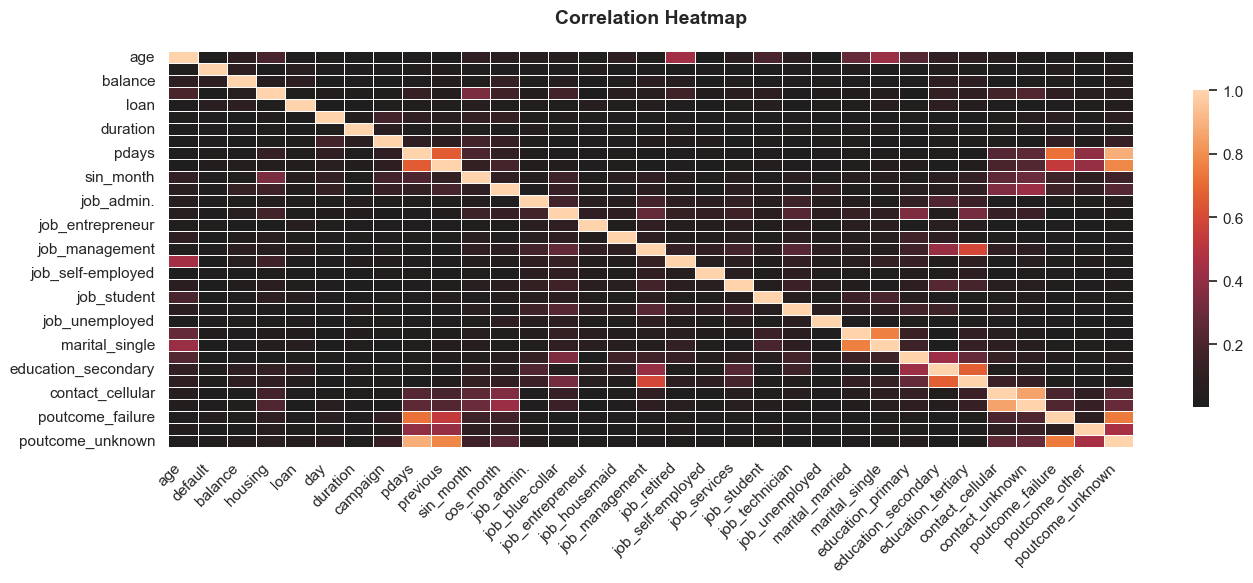

In [14]:
plt.figure(figsize=(14, 6))
corr = data_X_df.corr().abs()

ax = sns.heatmap(
    corr,
    # annot=True,
    # fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

## 1.2 Handle Multi Colinearity

In [15]:
X_reduced, dropped_cols = drop_highly_correlated(data_X_df, data_y_df.squeeze(), threshold=0.65)
print(dropped_cols)
X_reduced.shape

pdays ↔ previous | corr=0.663 | drop=pdays
pdays ↔ poutcome_failure | corr=0.722 | drop=poutcome_failure
previous ↔ poutcome_unknown | corr=0.776 | drop=previous
marital_married ↔ marital_single | corr=0.764 | drop=marital_single
education_secondary ↔ education_tertiary | corr=0.666 | drop=education_secondary
contact_cellular ↔ contact_unknown | corr=0.859 | drop=contact_cellular

Columns to drop (6): ['contact_cellular', 'education_secondary', 'marital_single', 'pdays', 'poutcome_failure', 'previous']
['pdays', 'marital_single', 'poutcome_failure', 'contact_cellular', 'previous', 'education_secondary']


(4521, 27)

In [16]:
X_vif_reduced, final_vif_df = drop_high_vif_features(X_reduced, threshold=6.5)



Iteration 1:
Dropping 'age' (VIF = 20.74)

Iteration 2:
Dropping 'poutcome_unknown' (VIF = 7.91)

Iteration 3:

 All VIFs ≤ 6.5. Stopping.


In [17]:
final_vif_df

,feature,VIF
0,default,1.033519
1,balance,1.362931
2,housing,2.859776
3,loan,1.212287
4,day,4.867391
5,duration,2.194176
6,campaign,2.267504
7,sin_month,1.292447
8,cos_month,2.088520
9,job_admin.,2.040719


In [18]:
X_vif_reduced.shape

(4521, 25)

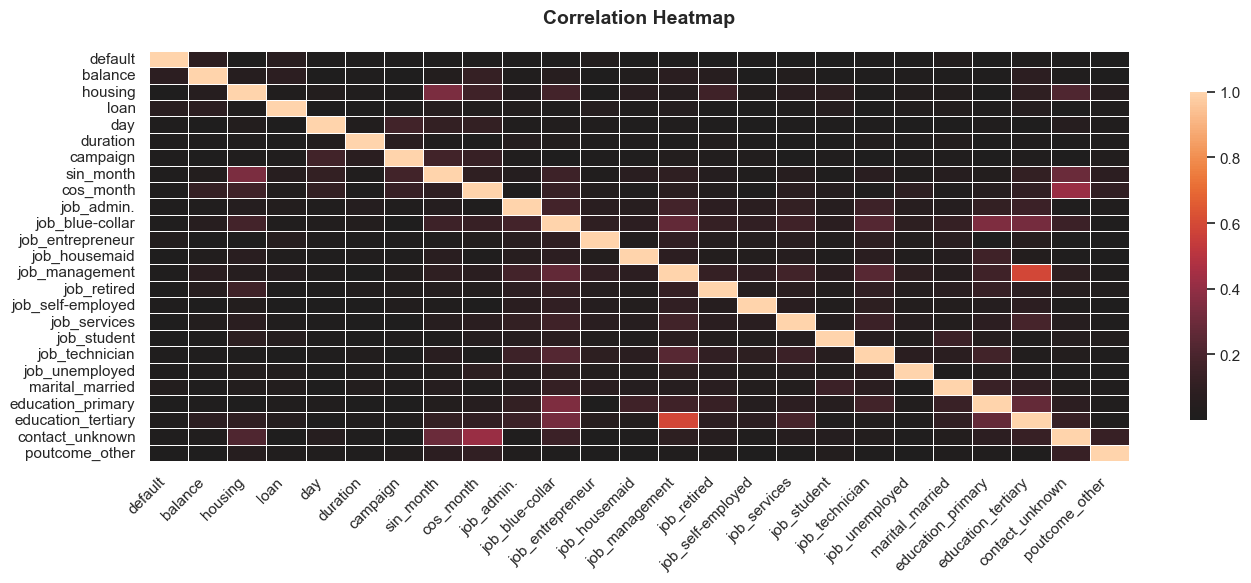

In [19]:
plt.figure(figsize=(14, 6))
corr = X_vif_reduced.corr().abs()

ax = sns.heatmap(
    corr,
    # annot=True,
    # fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

# 2. Model Builder

In [20]:
model_builder = GMMModelBuilder(X_vif_reduced)
model_builder.scale_data()


Data successfully scaled using StandardScaler.


K=2: AIC=95003.03, BIC=99500.98, Silhouette=0.0801, CH=308.83, DB=3.6562
K=3: AIC=-96147.67, BIC=-89397.53, Silhouette=0.0867, CH=267.07, DB=3.3967
K=4: AIC=-231035.22, BIC=-222032.89, Silhouette=0.1087, CH=298.09, DB=2.8658
K=5: AIC=-265517.62, BIC=-254263.10, Silhouette=0.1454, CH=305.86, DB=2.5442
K=6: AIC=-305879.57, BIC=-292372.86, Silhouette=0.1417, CH=306.58, DB=2.2380
K=7: AIC=-357717.92, BIC=-341959.02, Silhouette=0.1499, CH=292.49, DB=2.3994
K=8: AIC=-386050.28, BIC=-368039.20, Silhouette=0.1864, CH=318.62, DB=2.1970
K=9: AIC=-420761.25, BIC=-400497.98, Silhouette=0.2124, CH=346.25, DB=1.8884
K=10: AIC=-437092.95, BIC=-414577.49, Silhouette=0.2197, CH=368.56, DB=1.6053
K=11: AIC=-436413.15, BIC=-411645.51, Silhouette=0.2315, CH=384.61, DB=1.5333
K=12: AIC=-480508.18, BIC=-453488.35, Silhouette=0.2108, CH=358.71, DB=1.6197
K=13: AIC=-485349.59, BIC=-456077.56, Silhouette=0.2225, CH=373.50, DB=1.6112
K=14: AIC=-506424.29, BIC=-474900.08, Silhouette=0.1799, CH=318.72, DB=1.8481


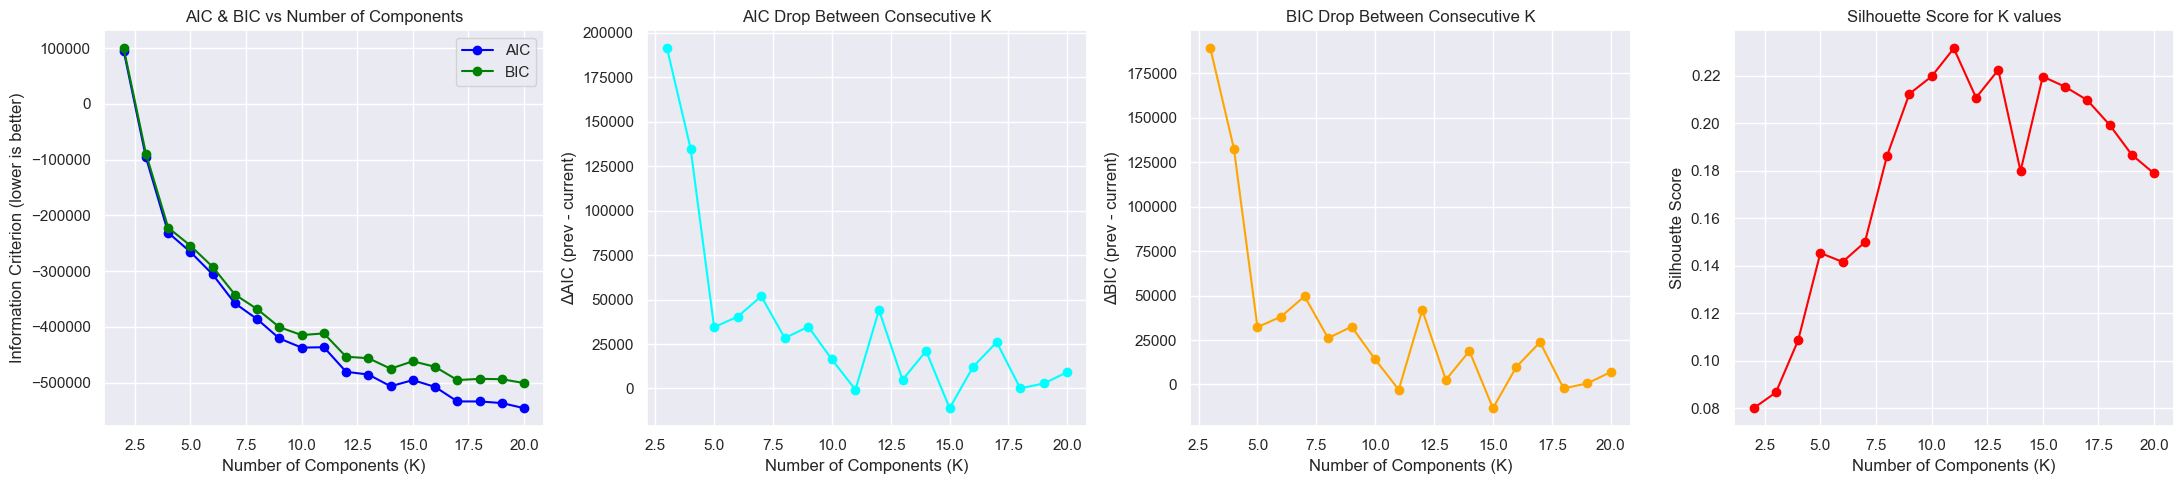

In [21]:
model_builder.evaluate_k_values(20)

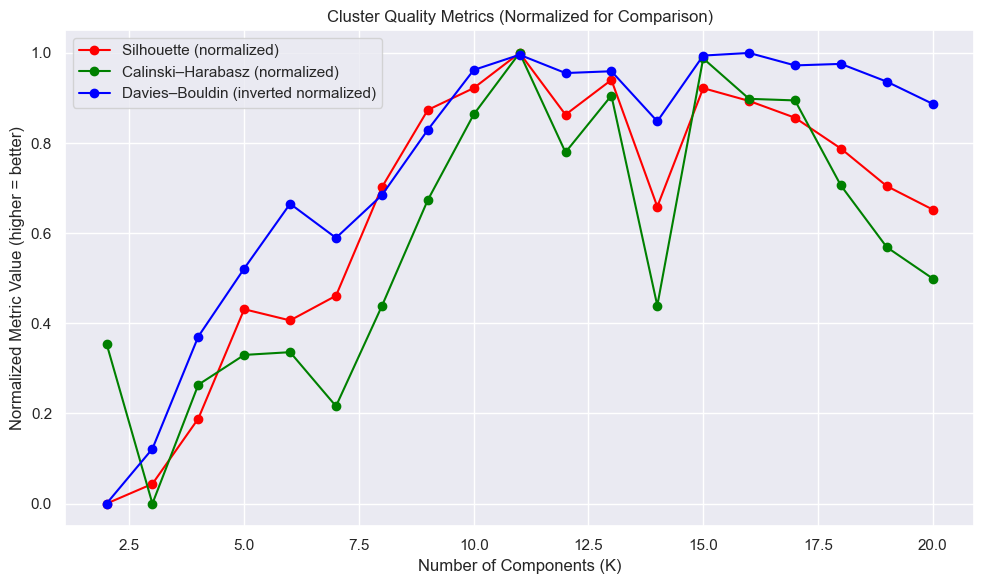

In [22]:
model_builder.plot_cluster_quality_metrics(20)

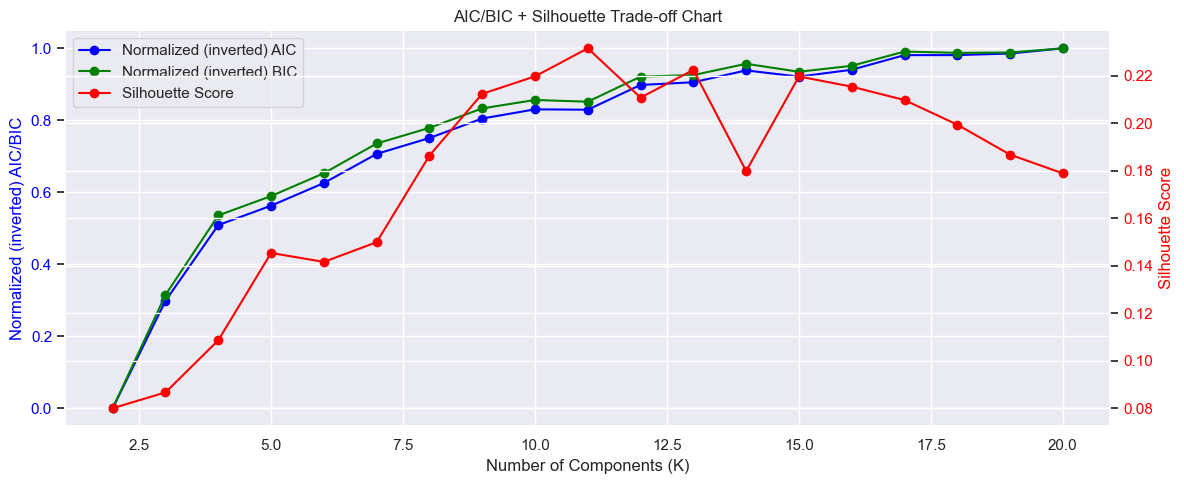

In [23]:
model_builder.plot_tradeoff(20)

# 3. Result

In [24]:
labels = model_builder.build_final_model(11)


Final GMM model built with K=11
AIC: -436413.15, BIC: -411645.51, Silhouette: 0.2315


In [25]:
labels_df = pd.DataFrame(labels)

In [26]:
clustered_df = X_vif_reduced.copy(deep = True)
clustered_df = pd.concat(
    [clustered_df, labels_df],
    axis = 1
)
clustered_df = clustered_df.rename(
    columns  = {
        0 : "Cluster"
    }
)

clustered_df["Cluster"].value_counts(normalize = True)
# clustered_df.head()

Cluster
2     0.211236
1     0.206149
0     0.166556
7     0.163017
4     0.090688
6     0.039593
10    0.035612
9     0.027649
5     0.024331
3     0.018359
8     0.016810
Name: proportion, dtype: float64

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(clustered_df.drop("Cluster", axis=1))
y = clustered_df.loc[:, "Cluster"]

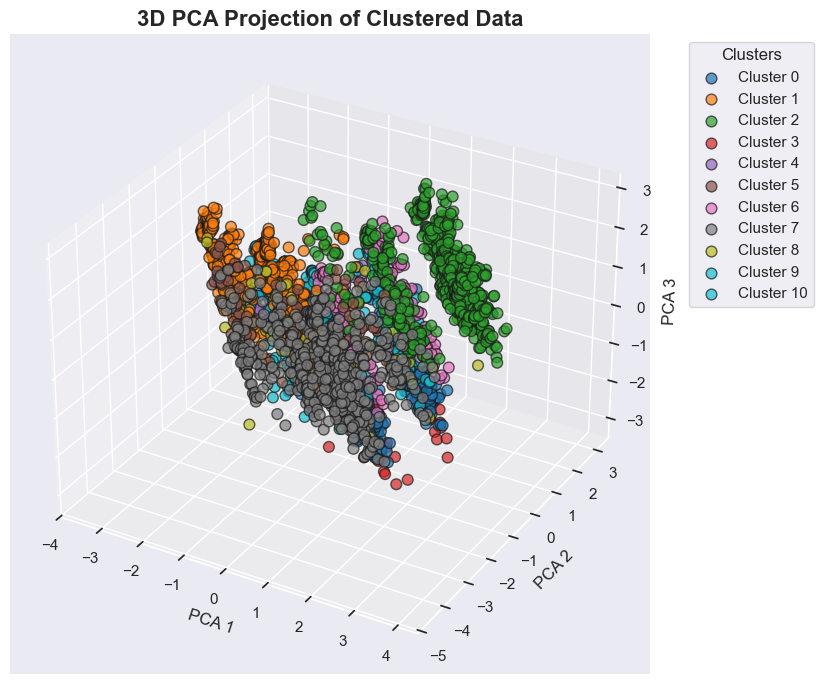

In [28]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Use a discrete colormap and one color per cluster
unique_clusters = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    mask = (y == cluster)
    ax.scatter(
        X_pca_3d[mask, 0],
        X_pca_3d[mask, 1],
        X_pca_3d[mask, 2],
        label=f"Cluster {cluster}",
        color=color,
        alpha=0.7,
        s=60,
        edgecolor="k"
    )

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Clustered Data", fontsize=16, weight="bold")

ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# END